[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial3.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: Future climate scenarios & Multi-model Ensembles

**By Sciencematch Academy**

**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson, Julius Busecke, Tom Nicholas, Sam Ditkovsky

**Content reviewers:** Younkap Nina Duplex, Zahra Khodakaramimaghsoud, Sloane Garelick, Peter Ohue, Jenna Pearson, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS, Google DeepMind, and CMIP

# Tutorial Objectives
In this tutorial, we will analyze data from five different CMIP6 models developed by various institutions around the world, focusing on their *historical* simulations and low-emission projections (*SSP1-2.6*). By the end of this tutorial, you will be able to 
- Load CMIP6 Sea Surface Temperature (SST) data from multiple models;
- Calculate the SST anomalies, and recall the concept of temperature anomaly in relation to a base period

# Setup

    



In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

In [2]:
# imports
import time

tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

In [3]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

%matplotlib inline

In [4]:
# @title Helper functions

def readin_cmip6_to_datatree(facet_dict):
    # open an intake catalog containing the Pangeo CMIP cloud data
    col = intake.open_esm_datastore(
        "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    )

    # from the full `col` object, create a subset using facet search
    cat = col.search(
        source_id=facet_dict['source_id'],
        variable_id=facet_dict['variable_id'],
        member_id=facet_dict['member_id'],
        table_id=facet_dict['table_id'],
        grid_label=facet_dict['grid_label'],
        experiment_id=facet_dict['experiment_id'],
        require_all_on=facet_dict['require_all_on']  # make sure that we only get models which have all of the above experiments
    )

    # convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
    kwargs = dict(
        preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
        xarray_open_kwargs=dict(
            use_cftime=True
        ),  # ensure all datasets use the same time index
        storage_options={
            "token": "anon"
        },  # anonymous/public authentication to google cloud storage
    )

    cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
    dt = cat.to_datatree(**kwargs)
    
    return dt


def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)

In [5]:
# @title Video 1: Why So Many Earth System Models?

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'sTYK2TAPycs'), ('Bilibili', 'BV1Ua4y1F78Z')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [6]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "6y2fp"

download_link = f"https://osf.io/download/{link_id}/"
render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# @markdown
out = widgets.Output()
with out:
    print(f"If you want to download the slides: {download_link}")
    display(IFrame(src=f"{render_link}", width=730, height=410))
display(out)

Output()

# Section 1: Load CMIP6 SST Data from Five Models and Three Experiments
In the previous section, you investigated the internal variability in a single CMIP6 model (*TaiESM1*) simulated past temperature. 

Now we will start to analyze a **multi-model ensemble** that consists of data from multiple CMIP6 models, and includes both historical simulations and future scenario projections.

Your multi-model ensemble will consist of **Five** different CMIP6 models developed by institutions from a variety of countries: 
  * *TaiESM1* (Research Center for Environmental Changes, Taiwan),
  * *IPSL-CM6A-LR* (Institut Pierre Simon Laplace, France),
  * *GFDL-ESM4* (NOAA Geophysical Fluid Dynamics Laboratory, USA), 
  * *ACCESS-CM2* (CSIRO and ARCCSS, Australia), and 
  * *MPI-ESM1-2-LR* (Max Planck Institute, Germany). 

We can specify these models through the *source_id* facet. You can see a [table of CMIP6 *source_id* values here](https://www.google.com/url?q=https://airtable.com/shrvRybShvNSE1Szp/tblC0DBPiCm7gjJqx&sa=D&source=docs&ust=1689235930798709&usg=AOvVaw06jpHwjNGxPR1yILwtX5qB), and you can learn more about CMIP through our [CMIP Resource Bank](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md) and the [CMIP website](https://wcrp-cmip.org/).

Note that these are only a subset of the dozens of models, institutes, countries, and experiments that contribute to CMIP6, as discussed in the previous W2D1 Tutorial 2 video. Some of the abbreviations in the model names refer to institutes (*MPI/GFDL*), while some refer to the complexity and version of the model (e.g., Earth System or Climate Model [*ESM/CM*] and low- or high-resolution [*LR/HR*]). There are often several models from a single institute with each having a distinct level of complexity.

In [7]:
# selected CMIP6 models to explore
source_ids = ["IPSL-CM6A-LR", "GFDL-ESM4", "ACCESS-CM2", "MPI-ESM1-2-LR", "TaiESM1"]

# dictionary of facets for query of surface temperature data
facet_dict = { "source_id":source_ids,
    "variable_id":"tos",
    "member_id":"r1i1p1f1",
    "table_id":"Omon",
    "grid_label":"gn",
    "experiment_id":["historical", "ssp126", "ssp585"],
    "require_all_on":"source_id"
    }

# dictionary for query of cell area metric
facet_dict_area = { "source_id":source_ids,
    "variable_id":"areacello",
    "member_id":"r1i1p1f1",
    "table_id":"Ofx",
    "grid_label":"gn",
    "experiment_id":"historical",
    "require_all_on":"source_id"
    }

# search for temperature and area data and return datatree objects
dt = readin_cmip6_to_datatree(facet_dict)
dt_area = readin_cmip6_to_datatree(facet_dict_area)

# merge area metric into datatree object
dt_with_area = DataTree()
for model, subtree in dt.items():
    metric = dt_area[model]["historical"].ds["areacello"]
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


Let's first reproduce the previous tutorial's timeseries of Global Mean SST from *TaiESM1* through the historical experiment and two future emissions scenarios

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/var/folders/hw/qnv0wm_x4p7bt8y7tw33cxjh0000gn/T/ipykernel_66205/2852967650.py:9: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel("Global Mean SST [$^\circ$C]")


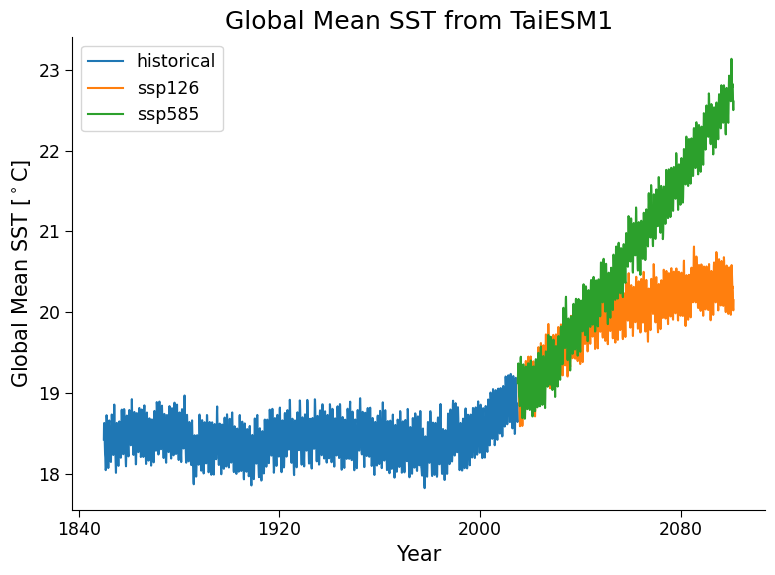

In [8]:
# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

fig, ax = plt.subplots()
for experiment in ["historical", "ssp126", "ssp585"]:
    da = dt_gm["TaiESM1"][experiment].ds.tos
    da.plot(label=experiment, ax=ax)
ax.set_title("Global Mean SST from TaiESM1")
ax.set_ylabel("Global Mean SST [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()

### **Coding Exercise 1.1: Combine past and future data, remove seasonal oscillations, and plot all 5 of the CMIP6 models we just loaded**

* The historical and projected data are separate time series. Complete the `xr.concat` function to combine the historical and projected data into a single continuous time series for each model.
* The previous time series oscillated very rapidly due to Earth's seasonal cycles. Finish the `xarray` `resample` function so that it smooths the monthly data with a one-year running mean. This will make it easier to distinguish the long-term changes in sea surface temperature.
* Note: this code is already set up to use all 5 of the CMIP6 models you just loaded, as it loops through and plots each model in the DataTree [`dt.keys()`]

In [9]:
#################################################
## TODO for students: Plot annually smoothed global mean SST for all models##
# please remove the following line of code once you have completed the exercise:
raise NotImplementedError("Student exercise: Plot annually smoothed global mean SST for all models")
#################################################


def plot_historical_ssp126_combined(dt, ax):
    for model in dt.keys():
        datasets = []
        for experiment in ["historical", "ssp126"]:
            datasets.append(dt[model][experiment].tos)

        # for each of the models, concatenate its historical and future data
        da_combined = xr.concat(...)
        # plot annual averages
        da_combined.coarsen(...).mean().plot(label=model, ax=ax)


fig, ax = plt.subplots()
# plot_historical_ssp126_combined
_ = ...

ax.set_title("Global Mean SST from five CMIP6 models (annually smoothed)")
ax.set_ylabel("Global Mean SST [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()

<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
/var/folders/hw/qnv0wm_x4p7bt8y7tw33cxjh0000gn/T/ipykernel_66205/3264019162.py:25: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel("Global Mean SST [$^\circ$C]")
/var/folders/hw/qnv0wm_x4p7bt8y7tw33cxjh0000gn/T/ipykernel_66205/3264019162.py:25: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel("Global Mean SST [$^\circ$C]")


NotImplementedError: Student exercise: Plot annually smoothed global mean SST for all models

<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/var/folders/hw/qnv0wm_x4p7bt8y7tw33cxjh0000gn/T/ipykernel_66205/1405952321.py:20: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel("Global Mean SST [$^\circ$C]")


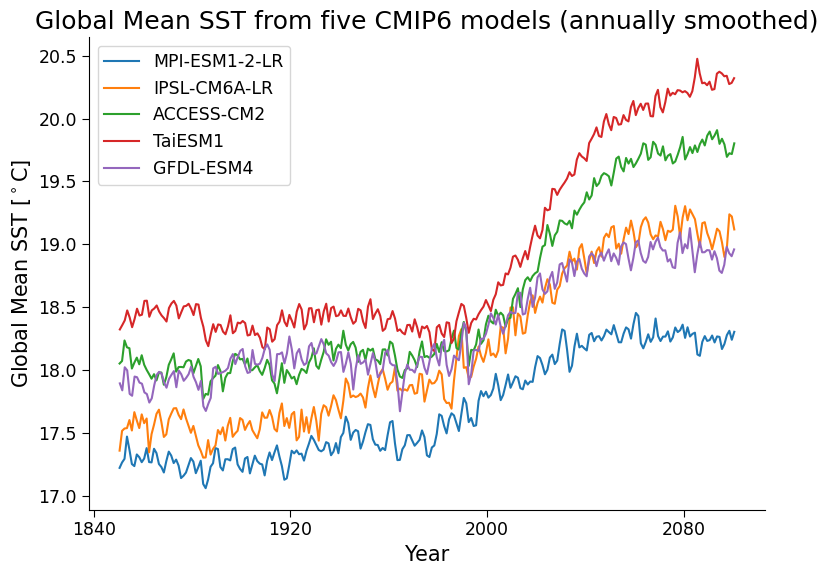

In [10]:
# to_remove solution

def plot_historical_ssp126_combined(dt, ax):
    for model in dt.keys():
        datasets = []
        for experiment in ["historical", "ssp126"]:
            datasets.append(dt[model][experiment].tos)

        # for each of the models, concatenate its historical and future data
        da_combined = xr.concat(datasets, dim="time")
        # plot annual averages
        da_combined.coarsen(time=12).mean().plot(label=model, ax=ax)


fig, ax = plt.subplots()
# plot_historical_ssp126_combined
_ = plot_historical_ssp126_combined(dt_gm, ax)

ax.set_title("Global Mean SST from five CMIP6 models (annually smoothed)")
ax.set_ylabel("Global Mean SST [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()

### **Question 1.1**

1.   Why do you think the global mean temperature varies so much between models?* 

**If you get stuck here, reflect on the videos from earlier today and the tutorials/videos from the Climate Modelling day for inspiration.*

In [11]:
# to_remove explanation

"""
1. Each of these models has slightly different physics, numerics, and discretization. During the Climate Modeling, day you showed that Earth's theoretical equilibrium temperature under fixed insolation changes as more details/complexity of the real Earth system are included. Similarly, the small differences between models result in each model having a slightly different equilibrium temperature for a given insolation, which also manifests in these long-term these simulations.
""";

### Coding Exercise 1.2

As you just saw, the global mean SST varies between climate models. This is not surprising given the slight differences in physics, numerics, and discretization between each model.

When we are looking at future projections, we care about how each model has *changed* relative to their equilibrium/previous state. To do this, we typically subtract a historical reference period from the timeseries. This creates a new timeseries which we call the temperature *anomaly* relative to that period. **Recall that you already calculated and used *anomalies* earlier in the course (e.g., on W1D1).**

**Modify the following code to recreate the previous multi-model figure, but now instead plot the global mean sea surface temperature (GMSST) *anomaly* relative the 1950-1980 base period (i.e., subtract the 1950-1980 mean GMSST of each model from that model's timeseries)**

*Hint: you will need to use `ds.sel` to select data during the base period ([see here](https://docs.xarray.dev/en/stable/user-guide/indexing.html#indexing-with-dimension-names) under "Indexing with dimension names" for a helpful example) along with the averaging operator, `mean()`.*

In [12]:
#################################################
## TODO for students: Plot global mean SST anomaly for all models##
# please remove the following line of code once you have completed the exercise:
raise NotImplementedError("Student exercise: Plot global mean SST anomaly for all models")
#################################################


# calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # find the temporal average over the desired reference period
        ref = ...
        dt_out[model] = subtree - ref
    return dt_out

# Uncomment below once you finish the above
# dt_gm_anomaly = datatree_anomaly(dt_gm)

fig, ax = plt.subplots()
# Uncomment below once you finish the above
# plot_historical_ssp126_combined(dt_gm_anomaly, ax)

ax.set_title(
    "Global Mean SST Anomaly from five CMIP6 models (base period: 1950 to 1980)"
)
ax.set_ylabel("Global Mean SST Anomaly [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()

<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
/var/folders/hw/qnv0wm_x4p7bt8y7tw33cxjh0000gn/T/ipykernel_66205/1673062644.py:27: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel("Global Mean SST Anomaly [$^\circ$C]")
/var/folders/hw/qnv0wm_x4p7bt8y7tw33cxjh0000gn/T/ipykernel_66205/1673062644.py:27: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel("Global Mean SST Anomaly [$^\circ$C]")


NotImplementedError: Student exercise: Plot global mean SST anomaly for all models

<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
/var/folders/hw/qnv0wm_x4p7bt8y7tw33cxjh0000gn/T/ipykernel_66205/4008179974.py:24: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel("Global Mean SST Anomaly [$^\circ$C]")


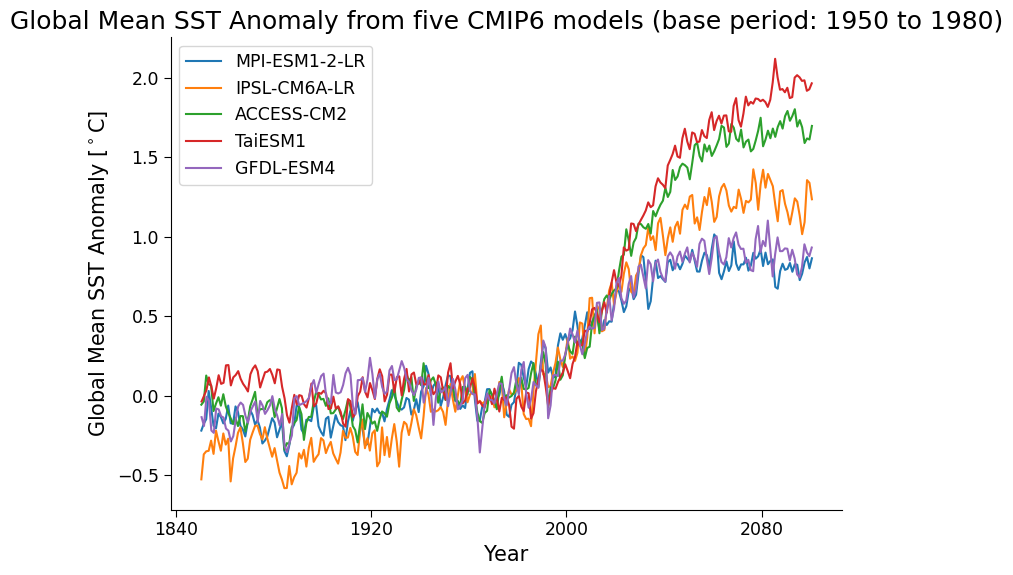

In [13]:
# to_remove solution

# calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # find the temporal average over the desired reference period
        ref = dt[model]["historical"].ds.sel(time=slice("1950", "1980")).mean()
        dt_out[model] = subtree - ref
    return dt_out

# Uncomment below once you finish the above
# dt_gm_anomaly = datatree_anomaly(dt_gm)
dt_gm_anomaly = datatree_anomaly(dt_gm)

fig, ax = plt.subplots()
# Uncomment below once you finish the above
# plot_historical_ssp126_combined(dt_gm_anomaly, ax)
plot_historical_ssp126_combined(dt_gm_anomaly, ax)

ax.set_title(
    "Global Mean SST Anomaly from five CMIP6 models (base period: 1950 to 1980)"
)
ax.set_ylabel("Global Mean SST Anomaly [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend()

### **Questions 1.2: Climate Connection**

1.  How does this figure compare to the previous one where the reference period was not subtracted?
2.  This figure uses the reference period of 1950-1980 for its anomaly calculation. How does the variability across models 100 years before the base period (1850) compare to the variability 100 years after the base period (2080)? Why do you think this is?


In [14]:
# to_remove explanation

"""
1. The models agree much better across this time period, particularly in the reference period and during the rapid warming phase projected in the near future.
2. There is variability at both ends of the scale, but the future (2080) period has more inter-model variability than the past (1850) period. This is likely because each of these models has a simulates a unique climate system, as we found in the last question, which leads to different responses to the rapid  changes in effective radiative forcing that are projected in the near future.
""";

# Summary

In this tutorial, we expanded on the previous examination of a single CMIP6 model (*TaiESM1*), to instead work with multi-model ensemble comprising five different CMIP6 models developed by institutions around the world (*TaiESM1*, *IPSL-CM6A-LR*, *GFDL-ESM4*, *ACCESS-CM2*, and *MPI-ESM1-2-LR*). We demonstrated the importance of anomalizing each of these models relative to a base period when calculating changes in the simulated Earth system. If variables are not anomalized, these absolute values can differ significantly between models due to the diversity of models (i.e., their distinct physics, numerics and discretization).

# Resources

This tutorial uses data from the simulations conducted as part of the [CMIP6](https://wcrp-cmip.org/) multi-model ensemble. 

For examples on how to access and analyze data, please visit the [Pangeo Cloud CMIP6 Gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html) 

For more information on what CMIP is and how to access the data, please see this [page](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).